# TP2
- Master MVA ENS-Paris Saclay
- Balthazar Neveu
- balthazarneveu@gmail.com

# Default denoisers

Evaluated on observation with additive white gaussian noise. $sigma_{255}=40$
| $u$ = Original / $\tilde{u}$ = Noisy | 
|:--:|
| ![](figures/in_out.png) |
|Denoised with standard, non tuned denoisers|
| ![](figures/basic_default_denoisers.png) |


- TV-Denoising has not been tuned (and it can do better as we'll see later).
- DN-CNN trained with a noise level $sigma_{255}=40$ is used here - so the denoising network is expected to work : there's no gap between its training conditions and evaluation conditions.
- BM3D is used with the right noise input level (`BM3DDenoiser(40)`), it is a non machine learning based algorithm. 

| BM3D with different tunings.|
|:--:|
| ![bm3d_sensitivity](figures/BM3D_tuning.png) |
|On the left, BM3D would expect a not too noisy image and so leave a lot of residual noise. On the right side, BM3D runs on an image where that was more noisy that reality so it ends up oversmoothing|

## Optimal TV Denoiser

**Auto tuning TV denoiser**

### Question 1


```python
for i in range(1,100):
    uTV = TVDenoiser(lamb=TVlamb,niter=100).denoise(utilde)
    res = rmse(uTV,utilde)
    # Estimated residual between the noisy image and the denoised image
    error = rmse(uTV,u)
    # True error between the prediction and the clean image
    non_gaussianity_error = sigma1*beta-res
    # if the error was gaussian with the right amount of noise, this should be 0
    correction_factor = rho*non_gaussianity_error
    TVlamb *= np.exp(correction_factor)
    stop_cond= np.fabs(non_gaussianity_error) < 0.01 * (sigma1*beta)
    if stop_cond:
        break
```

### Question 2

Initial tuning : $\lambda^{TV}_{\text{n=0}} = 0.024 =  \sigma^2$

$\rightarrow  \lambda^{TV}_{n=6} \approx 0.125 \approx 5.1 \sigma^ 2 $ to achieve a 1% tolerance (`residual/sigma = 0.955`)

Although simple, the proposed automatic tuning technique seems to be quite robust to initial values. Even if you start with a high value for $\lambda$ like $10 \sigma^{2}$ where the initial images are oversmoothed, the tuning parameter correction converges to the right value.

![](figures/tuning_parameter_convergence.png)



![](figures/single_standalone_awgn_denoisers.png)

|Denoiser | RMSE(normalized gray levels) | PSNR(dB) |
|:---:|:---:|:---:|
|Tuned TV Denoiser |  0.0630 | 24.0 dB |
|DnCNN Denoiser | 0.0450 | 26.9 dB |
|Real SN_DnCNN | 0.0448 | 27.0 dB |

`Real_SN_DnCNN` and `DnCNN` denoising have similar denoising quality, and way better than the correctly tuned TV denoiser  

### Question 3 
`RealSN_DnCNN` has the same exact architecture as `DnCNN` but has been trained in a very specific fashion:
The residual satisfies the Lipschitz constraint. This will not change anything to the denoising capabilities of the network under AWGN (this is what we observed in the previous table in question 2., additionnally the 2 denoised results look very much alike visually).

The only difference is part of the training: compared to a "classical" MSE minimization with gradient descent the weights are modified during training so that the residual satisfies the Lipschitz constraint (Relu is 1-Lipschitz, Convolutions coefficients at each layer need to be normalized by their largest eigen value). RealSN stands for real Spectral Normalization and uses a "tricky" implementation (not naïvely performing SVD at each step, instead relying on an iterative power method = avoids computing SVD at every training step for all netwrok layers).

### Question 4 

$\alpha = \frac{\sigma^2}{\gamma}$

In [ ]:
def prox_datafit_gaussian_denoising(x, y, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    prox_{alpha f} (x) = (x + y*alpha/s^2)/(1+alpha/s^2)

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    a = alpha/(s**2)
    v = (x+y*a)/(1+a)
    return v


In the case where $s=\sigma$, the proximal term becomes
$\text{prox}_{\alpha.F(x)}=\frac{\gamma x+y}{\gamma +1}$ wich is a weighted sum of x and y (we're blending the denoised result from the Denoiser). When $\gamma=1$ , this is just the average $\frac{x+y}{2}$.

<!-- UNROLLING ADMM
Let's unroll the first iteration:
Init: 
- $u^{0}=0$ zero residual
- $y^{0} = x^{0} = \tilde{u}$ noisy image

- Step 1: (*Regularization*) - We first denoise the image.
$$x^{1} = \text{prox}_{\sigma^2 G}(y^{0}-u^{0}) \approx D_{\sigma}(y^{0}-u^{0}) = \text{Denoiser}_{\sigma}(\tilde{u})$$
- Step 2: (*Data term*) - We'll add back a bit of noise by averageing the denoised image with the original noisy image.
$$ y^{1} = \text{prox}_{\alpha F}(x^{1} + u^0, \tilde{u}) =  \frac{\gamma . (x^{1} + u^0)+\tilde{u}}{\gamma +1} = 
\frac{\gamma .\text{Denoiser}_{\sigma}(\tilde{u})  + \tilde{u}}{\gamma +1}$$ -->


<!-- - Step 3: Estimated residual $$u_1 = \frac{x^{1}-y^{0}}{2} =  \frac{\text{Denoiser}_{\sigma}(\tilde{u}) - \tilde{u}}{\gamma+1}$$ -->


<!-- $ y^{k+1} = \text{prox}_{\alpha F}(x^{k+1} + u^k) $ -->
<!-- $$\text{prox}_{\sigma^2 G}(x) \approx D_{\sigma}(x)$$ -->

The $\gamma$ parameter definitely acts as a tuning parameter for the denoiser as can be seen in the next figure. Good news is that compared to the "classic trick" (telling the network to process the image with a tweaked noise value), this tuning parameter actually seems to make sense. 

| $\gamma=0.8$ | $\gamma=1.0$ | $\gamma=1.2$ |
|:----:|:----:|:----:|
|![](figures/drs_same_noise_gamma_0p8.png) |![](figures/drs_same_noise_gamma_1p0.png)|![](figures/drs_same_noise_gamma_1p2.png) |

# Auto tuning of PnP Gaussian denoising

### Question 5

| $\sigma = 5$ | $\sigma = 15$ | $\sigma = 40$ |
|:-----: |:-----: |:-----: |
| $\gamma=0.351$|  $\gamma=0.5723$  | $\gamma=1.3715$ | 
|Condition $\gamma<0.062$ | Condition $\gamma<0.55$ |   Condition $\gamma<3.9$ |
|SNR=21.85dB | SNR=23.28dB | SNR=22.90dB |
|PSNR=27.30dB | PSNR=28.74dB | PSNR=28.35dB |
#### 5.1 Convergence conditions:
- Since $F(x) = \frac{\|x-y\|^{2}}{2s^2}$ is a quadaratic function, it is $\mu = \frac{1}{s^2} $ strictly -convex 
- $\gamma$  shall therefore the following conditions $$\gamma \leq \frac{\sigma^2}{s^2} .(\frac{1+L-2L^2}{L})$$
- We know that the SN_DnCNN has been trained with the right Lipschitz constraint, we have $0<L<1$ we find that the constant is approximately . 
  - From the Ryu paper, `Plug-and-Play Methods Provably Converge with Properly Trained Denoisers`, we can get the estimations of the Lipschitz constant $L\approx 0.464$  for DnCNN.

![](figures/lipschitz_constants_estimator.png)

- We can therefore deduce the maximum value of Gamma for each noise level of the pretrained denoisers.

![](figures/gamma_convergence_limits.png)

- It's clear that the optimum $\gamma=0.35 >0.062$ found when $\sigma=5$ violates the constraint, which propbably explain why we observe a bunch of artifacts.  
- At $\sigma=15$, the optimum $\gamma=0.57 \approx 0.557$ is close to the limit conditions but works correctly.

2.
1. Best results are obtained for $sigma=15$ (a denoiser trained for noises lower than $s=30$).


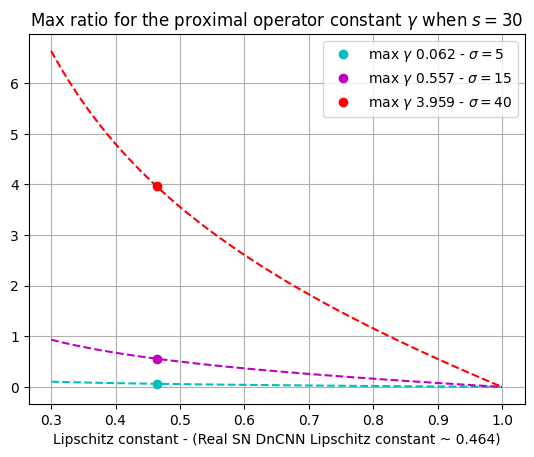

In [37]:
import matplotlib.pyplot as plt; import numpy as np
real_sn_dn_cnn_lipschitz = 0.464 # from the Ryu paper
lipschitz = np.linspace(0.3, 1, 100)
ratio = lambda l: (1+l-2*l**2)/l
s = 30
plt.xlabel('Lipschitz constant')
plt.title(f'Max ratio for the proximal operator constant $\gamma$ when $s={s}$')
colors = ['c', 'm', 'r' ]
for idx, sigma in enumerate([5, 15, 40]):
    noise_ratios = sigma**2/s**2
    max_ratio = noise_ratios*ratio(real_sn_dn_cnn_lipschitz)
    
    color = colors[idx]
    plt.plot(lipschitz, noise_ratios*ratio(lipschitz), color+"--")
    
    
    plt.plot(real_sn_dn_cnn_lipschitz, max_ratio, color+'o', label=f'max $\gamma$ {max_ratio:.3f} - $\sigma={sigma}$')
    plt.legend()
plt.xlabel(f'Lipschitz constant - (Real SN DnCNN Lipschitz constant ~ {real_sn_dn_cnn_lipschitz})')
plt.grid()
plt.show()


------
Results

| $\sigma = 5$ | $\sigma = 15$ | $\sigma = 40$ |
|:-----: |:-----: |:-----: |
|![](figures/pnp_drs_sigma=5.png) | ![](figures/pnp_drs_sigma=15.png) | ![](figures/pnp_drs_sigma=40.png) |

Observations:
- regarding the image on the right side of the table : The results when using PnP DRS for Gaussian Denoising with DnCNN at $\sigma=40$ are much better than if we'd simply performed inference with the DnCNN $\sigma=40$

![](figures/DnCNN_s=30_sigma=40.png)

- regarding the image on the left side of the table containing a bunch of weird artifacts, this may be an issue with convergence.

#### Cheatsheet
$\hat{x} = argmin F(x) + \lambda G(x) = \alpha * F(x) + \sigma^2 G(x)$

$\lambda = \frac{\sigma^2}{\alpha}$ , $\alpha<1$ to leave a bit of noise.

- $s$ actual standard deviation in $\tilde{u}$
- $\sigma$ noise standard deviation used to train the denoiser whose residual is considered as the poximal of $G$